# Testing classifiers using hctsa features for worm classification

In [1]:
#sets the notebook width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Third Party Libraries
import pandas as pd
import numpy as np
from scipy import stats
import random
from operator import itemgetter
# Graphs
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as plticker
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

In [4]:
# import matplotlib.font_manager
# matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

In [5]:
def stdfigsize(scale=1, nx=1, ny=1, ratio=1.61803398875):
    """
    Returns a tuple to be used as figure size.
    -------
    returns (7*ratio*scale*nx, 7.*scale*ny)
    By default: ratio=1.3
    If ratio<0 them ratio = golden ratio
    """
    if ratio < 0:
        ratio = 1.61803398875
    return((7*ratio*scale*nx, 7*scale*ny))

def stdrcparams(usetex=False):
    """
    Set several mpl.rcParams and sns.set_style for my taste.
    ----
    usetex = True
    ----
    """
    sns.set_style("white")
    sns.set_style({"xtick.direction": "in",
                 "ytick.direction": "in"})
    rcparams = {'text.usetex': usetex,
              'font.family': 'sans-serif',
              'font.sans-serif': ['Helvetica'],
              'text.latex.unicode': True,
              'text.latex.preamble': [r"\usepackage[T1]{fontenc}",
                                      r"\usepackage{lmodern}",
                                      r"\usepackage{amsmath}",
                                      r"\usepackage{mathptmx}"
                                      ],
              'axes.labelsize': 30,
              'axes.titlesize': 30,
              'ytick.right': 'on',
              'xtick.top': 'on',
              'xtick.labelsize': '25',
              'ytick.labelsize': '25',
              'axes.linewidth': 1.8,
              'xtick.major.width': 1.8,
              'xtick.minor.width': 1.8,
              'xtick.major.size': 14,
              'xtick.minor.size': 7,
              'xtick.major.pad': 10,
              'xtick.minor.pad': 10,
              'ytick.major.width': 1.8,
              'ytick.minor.width': 1.8,
              'ytick.major.size': 14,
              'ytick.minor.size': 7,
              'ytick.major.pad': 10,
              'ytick.minor.pad': 10,
              'axes.labelpad': 15,
              'axes.titlepad': 15,
              "xtick.direction": "in",
              "ytick.direction": "in"
              }
    mpl.rcParams.update(rcparams) 

stdrcparams(usetex=True)
figsize=stdfigsize()
print(figsize)

(11.32623792125, 7)


# Dataset

- Fulcher, Ben D., and Nick S. Jones. "hctsa: A computational framework for automated time-series phenotyping using massive feature extraction." Cell systems 5, no. 5 (2017): 527-531.

Running hctsa analysis on movement speed data of five strains of the nematode worm Caenorhabditis elegans: 
-  CB4856 (Hawaiian wild isolate)
-  N2 (lab) strains
-  dpy-20(e1282) (morphological mutant), 
-  unc-9(e101) (neural mutant), 
-  unc-38(e264) (neural mutant). 

In [7]:
features=pd.read_csv('../data/Operations.txt',sep=',',header=0)
features.head()

,ID,Name,CodeString,MasterID
0,1,length,ST_length,1
1,2,mean,DN_mean,5
2,3,harmonic_mean,DN_hmean,6
3,4,median,DN_median,8
4,5,trimmed_mean_1,DN_TrimmedMean_1,13


In [8]:
features.shape

(7749, 4)

In [9]:
labels=pd.read_csv('../data/TimeSeries.txt',header=0)
labels.tail()

,ID,Name,Keywords,Length
221,222,L_2011_03_30__16_16_31__11,N2,26195
222,223,R_2011_09_06__13_09___4___5,N2,26196
223,224,R_2011_08_11__11_21_44___2___5,N2,26196
224,225,L_2011_03_10__12_06_10__5,N2,26195
225,226,R_2011_08_25__15_18_49___1___8,N2,26197


In [10]:
labels.shape

(226, 4)

In [11]:
df=pd.read_csv('../data/TS_DataMat.txt',header=None,names=features.Name)
df['label']=labels.Keywords
df.head()

,length,mean,harmonic_mean,median,trimmed_mean_1,trimmed_mean_5,trimmed_mean_10,trimmed_mean_25,trimmed_mean_50,midhinge,...,MD_pNN_raw_pnn70,MD_pNN_raw_pnn80,MD_pNN_raw_pnn90,MD_pNN_raw_pnn100,MD_rawHRVmeas_tri10,MD_rawHRVmeas_tri20,MD_rawHRVmeas_trisqrt,MD_rawHRVmeas_SD1,MD_rawHRVmeas_SD2,label
0,26197,96.871907,140.677740,128.30300,97.924469,102.207039,107.152663,116.679003,123.497354,113.369062,...,0.954688,0.953084,0.951977,0.950679,2.206063,4.010563,25.458698,5243.147184,145208.136129,H
1,26156,56.922827,164.217475,62.21445,57.512988,59.572302,60.865024,62.585034,62.626973,63.248420,...,0.903040,0.902122,0.901013,0.899713,3.297113,6.359348,40.178187,7186.480481,134411.457022,H
2,26196,166.692488,221.567212,210.68050,168.344540,174.705555,182.039666,194.739157,204.566790,190.780500,...,0.913533,0.912121,0.910899,0.909143,2.379724,4.254669,28.692223,6301.131552,184379.343839,H
3,26195,66.528502,127.698183,72.69240,67.452627,69.522648,71.060958,72.662146,71.609526,72.506812,...,0.964725,0.963923,0.963083,0.961785,3.749642,6.928061,62.667464,6351.087348,137011.437636,H
4,26196,25.538206,64.533922,25.19215,25.815661,26.548793,26.521872,26.583173,26.163407,27.248878,...,0.951632,0.950716,0.949761,0.948998,2.508955,3.873429,30.746479,6606.623902,101062.677871,H


In [12]:
mapdummy=dict()
strlabels=list(set(labels.Keywords))
dummylabels=[1,2,3,4,5]
for i,key in enumerate(strlabels):
    mapdummy[key]=dummylabels[i]

In [13]:
df.label=df.label.map(mapdummy)

In [14]:
df=df.astype(float)
df.head().T

,0,1,2,3,4
length,2.619700e+04,2.615600e+04,2.619600e+04,26195.000000,26196.000000
mean,9.687191e+01,5.692283e+01,1.666925e+02,66.528502,25.538206
harmonic_mean,1.406777e+02,1.642175e+02,2.215672e+02,127.698183,64.533922
median,1.283030e+02,6.221445e+01,2.106805e+02,72.692400,25.192150
trimmed_mean_1,9.792447e+01,5.751299e+01,1.683445e+02,67.452627,25.815661
trimmed_mean_5,1.022070e+02,5.957230e+01,1.747056e+02,69.522648,26.548793
trimmed_mean_10,1.071527e+02,6.086502e+01,1.820397e+02,71.060958,26.521872
trimmed_mean_25,1.166790e+02,6.258503e+01,1.947392e+02,72.662146,26.583173
trimmed_mean_50,1.234974e+02,6.262697e+01,2.045668e+02,71.609526,26.163407
midhinge,1.133691e+02,6.324842e+01,1.907805e+02,72.506812,27.248878


In [15]:
def sigmoid_norm(feature):
    from scipy.stats import iqr
    return 1/(1+np.exp(-(feature-np.median(feature))/(1.35*iqr(feature))))

In [17]:
# Feature normalization
norm_max_data=df[df.columns[:-1]].apply(sigmoid_norm)
norm_max_data.dropna(axis=1,inplace=True)

Text(86.9361,0.5,'Tracks')

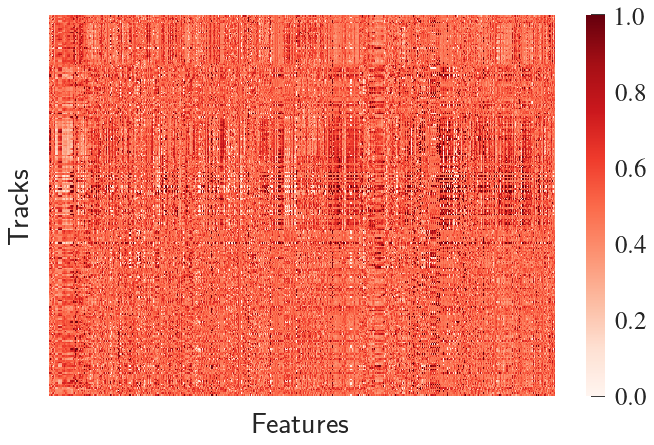

In [18]:
fig, ax = plt.subplots(figsize=figsize)
sns.heatmap(np.array(norm_max_data),cmap='Reds',ax=ax,yticklabels=[],xticklabels=[])
ax.set_xlabel(r'Features')
ax.set_ylabel(r'Tracks')

# Classification of phenotypes

In [19]:
#Classifiers
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Sampling to balance
from sklearn.utils import resample
#Preprocessing data
from sklearn import preprocessing
#Data split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
#Metrics to evalute
from sklearn import metrics
#Tunning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

In [20]:
print('Observations per class:')
print([(item,df[df.label==item].label.count()) for item in range(1,6)])

Observations per class:
[(1, 100), (2, 20), (3, 29), (4, 43), (5, 34)]


In [21]:
# Feature normalization
norm_max_data=df[df.columns[:-1]].apply(sigmoid_norm)
norm_max_data.dropna(axis=1,inplace=True)

In [22]:
norm_max_data.head()

,length,mean,harmonic_mean,median,trimmed_mean_1,trimmed_mean_5,trimmed_mean_10,trimmed_mean_25,trimmed_mean_50,midhinge,...,MD_pNN_raw_pnn60,MD_pNN_raw_pnn70,MD_pNN_raw_pnn80,MD_pNN_raw_pnn90,MD_pNN_raw_pnn100,MD_rawHRVmeas_tri10,MD_rawHRVmeas_tri20,MD_rawHRVmeas_trisqrt,MD_rawHRVmeas_SD1,MD_rawHRVmeas_SD2
0,5.915485e-01,0.654633,0.652786,0.681027,0.654809,0.654127,0.654032,0.658427,0.672736,0.653295,...,0.404962,0.405819,0.403903,0.405352,0.405702,0.463825,0.512197,0.511948,0.516725,0.569625
1,3.681353e-07,0.565010,0.696023,0.566550,0.564994,0.563479,0.560223,0.558009,0.562733,0.555459,...,0.190418,0.190443,0.189877,0.191155,0.192165,0.692465,0.726607,0.666679,0.715484,0.551315
2,5.000000e-01,0.785837,0.787292,0.797404,0.785889,0.783587,0.781674,0.780230,0.793199,0.780406,...,0.225952,0.226080,0.223996,0.224951,0.224271,0.501828,0.536264,0.547254,0.630074,0.634137
3,4.084515e-01,0.587199,0.627759,0.585547,0.587738,0.585267,0.581521,0.577355,0.579658,0.574109,...,0.454991,0.456573,0.459227,0.461979,0.462063,0.770022,0.768940,0.842809,0.635184,0.555739
4,5.000000e-01,0.491151,0.498419,0.498225,0.491087,0.489866,0.487300,0.487857,0.492930,0.481931,...,0.388278,0.390708,0.392081,0.394299,0.397344,0.530118,0.498644,0.569461,0.660826,0.494097


In [23]:
# Class weights 
class_weight=dict([(item,df[df.label==item].label.count()/len(df)) for item in range(1,6)])

In [24]:
# Defining classifiers
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3,n_jobs=-1),
    SVC(C=1.0, cache_size=200, class_weight=class_weight, coef0=0.0,
        decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False),
    SVC(C=1.0, cache_size=200, class_weight=class_weight, coef0=0.0,
        decision_function_shape='ovr', degree=3, gamma=2, kernel='rbf',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(n_estimators=500,max_depth=5,n_jobs=-1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]


In [25]:
# Calculate balanced score
def custom_score(y_pred,y_test,classes):
    scores=[]
    for cl in range(1,len(classes)+1):
        scores.append(list(y_pred[y_test==cl]).count(cl)/ len(y_test[y_test==cl]))
    score=sum(scores)/len(classes)
    return score

In [64]:
X=np.array(norm_max_data)
y=np.array(df.label)

cv_scores=[]
cv_cmatrices=[]
for i,clf in enumerate(classifiers):
    kf = StratifiedKFold(n_splits=10)
    kf.get_n_splits(X,y)
    scores=[]
    matrices=[]
    for train_index, test_index in kf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # Training the model
        clf.fit(X_train, y_train)
        # Class prediction
        y_pred=clf.predict(X_test)
        #Compute score
        score=custom_score(y_pred,y_test,np.unique(y_test))
        #Compute confusion matrix
        cm=metrics.confusion_matrix(y_test,y_pred)
        matrices.append(cm)
        scores.append(score)
    cv_cmatrices.append(matrices)
    cv_scores.append(scores)
    print(names[i],round(np.mean(cv_scores),2))

Nearest Neighbors 0.64
Linear SVM 0.72
RBF SVM 0.55
Gaussian Process 0.46
Decision Tree 0.49
Random Forest 0.52
Neural Net 0.49
AdaBoost 0.49
Naive Bayes 0.5
QDA 0.47


Text(0.5,0,'Model')

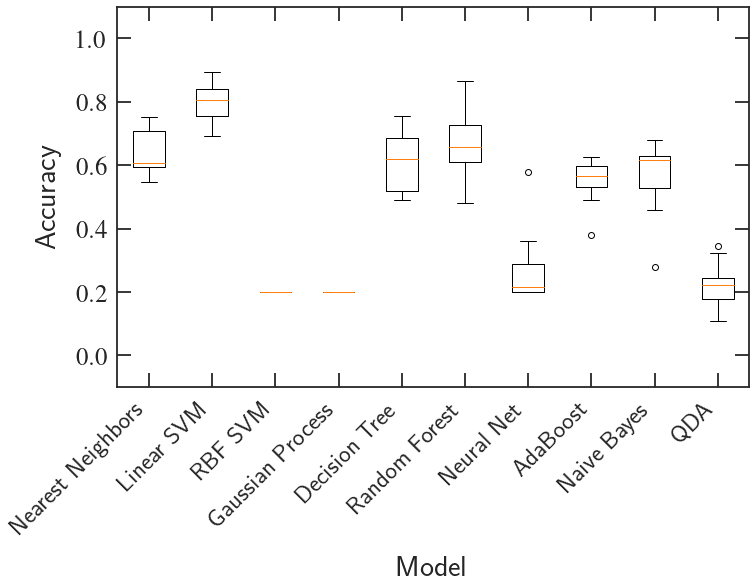

In [65]:
fig, ax = plt.subplots(figsize=figsize)
ax.boxplot(cv_scores)
ax.set_xticklabels(names,rotation=45,ha='right')
ax.set_ylim(-0.1,1.1)
plt.ylabel('Accuracy')
plt.xlabel('Model')

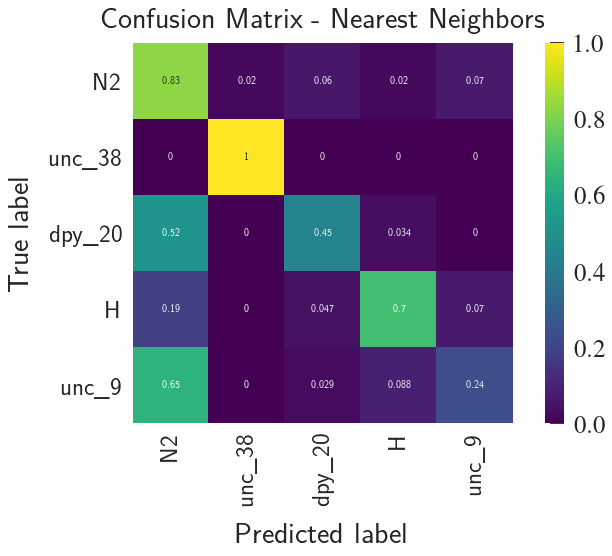

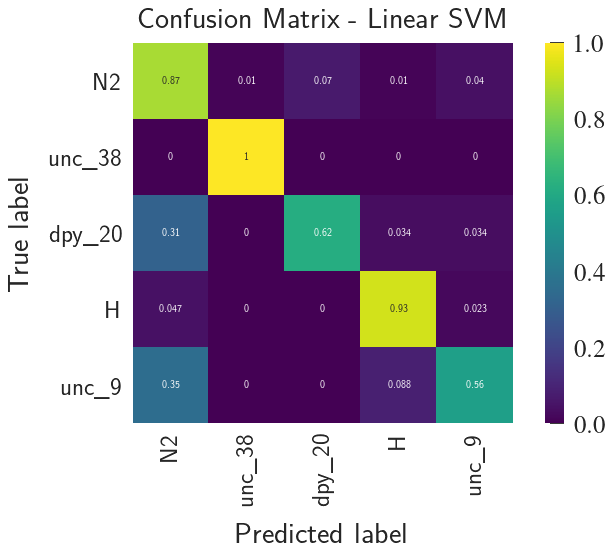

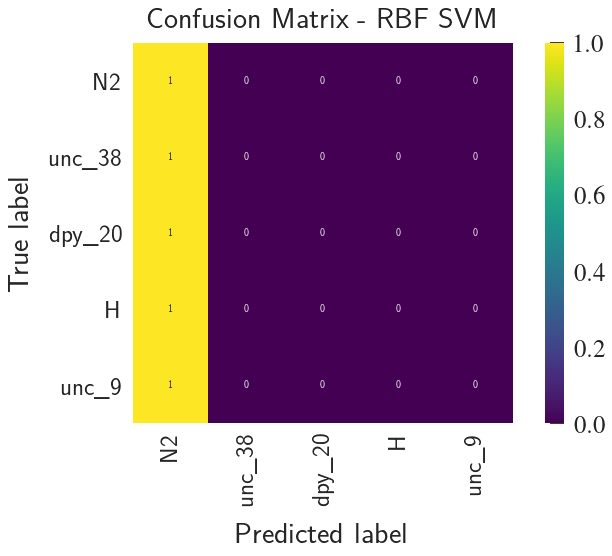

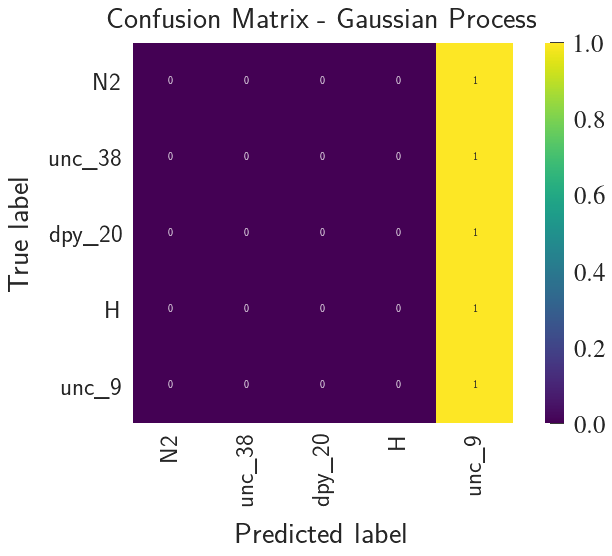

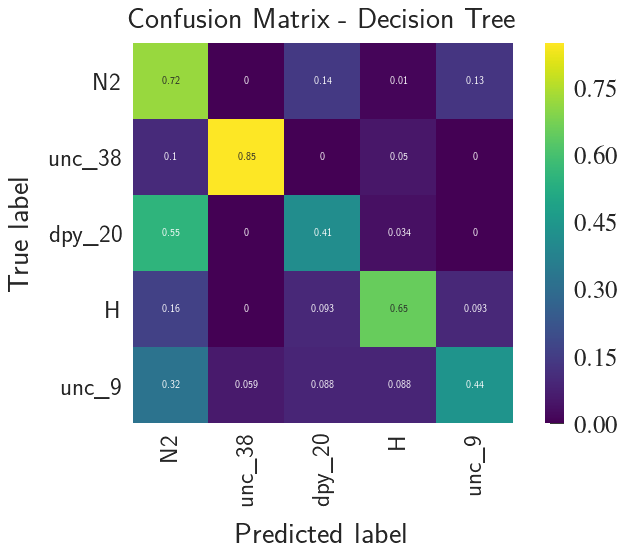

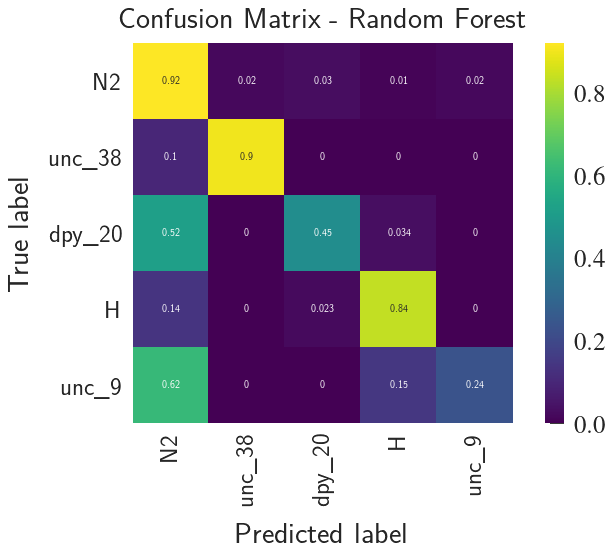

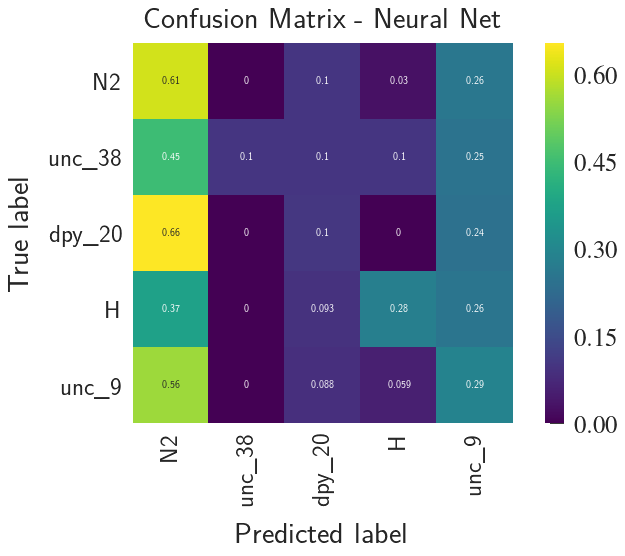

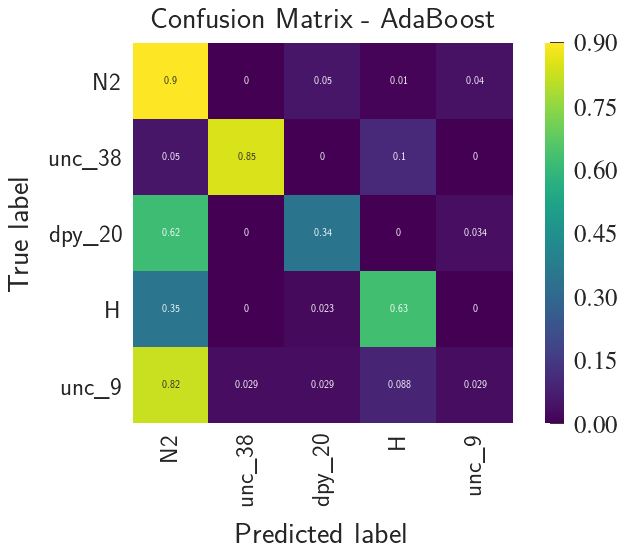

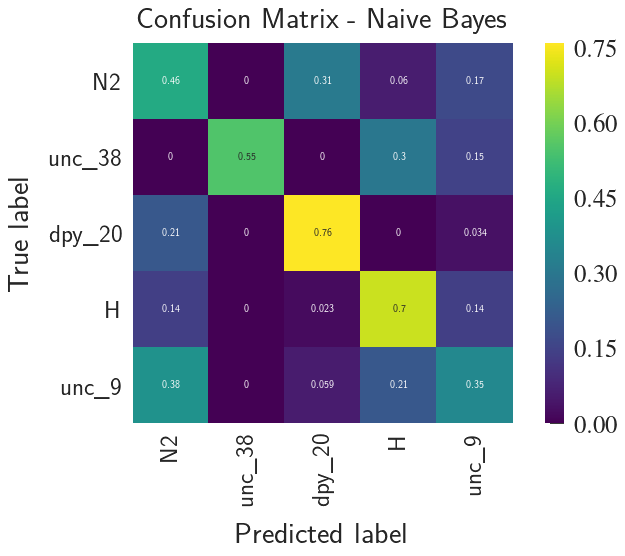

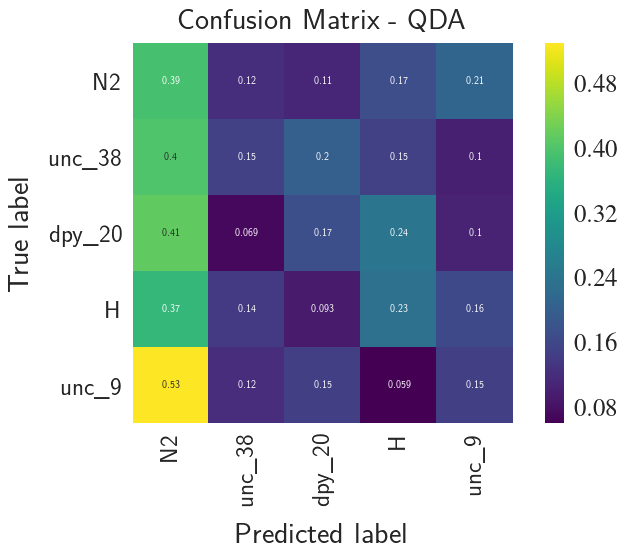

In [68]:
for i in range(0,len(names)):
    cm=np.zeros(cv_cmatrices[i][0].shape)
    for item in cv_cmatrices[i]:
        cm=cm+item
    cm=cm/len(cv_cmatrices[i])
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm,
                square=True,
                cmap='viridis',
                annot=True,
                xticklabels=['N2', r'unc$\_$38', r'dpy$\_$20', 'H', r'unc$\_$9'],
                yticklabels=['N2', r'unc$\_$38', r'dpy$\_$20', 'H', r'unc$\_$9'],
                ax=ax)
    plt.yticks(rotation=0) 
    plt.xticks(rotation=90) 
    plt.title('Confusion Matrix - {}'.format(names[i]))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()